# Where's the Best Place to Sell Books Online?
The e-commerce platform Flipkart hit an all-important milestone in 2018.
After beating out the world's largest online business, Amazon, for holding the top position in India's online retail market, the startup was acquired for by Wal-Mart for $18B USD.

It is commonly believed that startups can beat out larger businesses through differentiation, or being unique.

Will a machine learning classifier show us the differences between books being sold on Amazon vs. Flipkart?

# Setup for Data Analysis and ML Classifications

In [91]:
# libraries for Data Anaysis and Mathematical Computation
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import math
# visualizations
import seaborn as sns 
from mlxtend.plotting import plot_decision_regions
# run Matplotlib graphs inline in notebook
import matplotlib.pyplot as plt  
%matplotlib inline
# Required for Plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
# Machine Learning libraries 
import sklearn
# function used in building ML algorithms
from sklearn.model_selection import train_test_split
# imports the class to do standard scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Performing PCA
from sklearn.decomposition import PCA
# Model Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score 
# Sklearn Tools the ML Algorithms
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
# visualizing the Decision Tree and Random Forest
from sklearn.tree import export_graphviz
import pydotplus

### Instantiating pandas DataFrames

In [2]:
amazon_df = pd.read_csv('Data/amazon.csv')
flipkart_df = pd.read_csv('Data/flipkart.csv')
# View the data for book listings on Amazon
amazon_df.head()

,amazon_title,amazon_author,amazon_rating,amazon_reviews count,amazon_isbn-10,amazon_price
0,Tell Me your Dreams,by Sidney Sheldon,4.4,160.0,8172234902,209
1,The Boy in the Striped Pyjamas (Definitions),by John Boyne,4.6,134.0,1862305277,350
2,Romancing the Balance Sheet: For Anyone Who Ow...,by Anil Lamba,4.5,156.0,9350294311,477
3,Mossad,by Michael Bar-Zohar - Import,4.6,637.0,8184958455,340
4,My Story,by Kamala Das,4.5,42.0,8172238975,178


In [3]:
# do the same for Flipkart books sold
flipkart_df.head()

,flipkart_author,flipkart_isbn10,flipkart_title,flipkart_ratings count,flipkart_price,flipkart_stars
0,Sidney Sheldon,8172234902,TELL ME YOUR DREAMS,902,209,4.5
1,,1862305277,The Boy in the Striped Pyjamas,83,372,4.5
2,Anil Lamba,9350294311,ROMANCING THE BALANCE SHEET,352,477,4.5
3,Bar-Zohar Michael,8184958455,Mossad,560,280,4.5
4,Kamala Das,8172238975,MY STORY,322,178,4.3


## Fixing Data Inconsistencies

Several problems with the data have been identified, as it pertains to this analysis:

1. Columns are named differently across DataFrames
2. The columns are ordered differently across DataFrames
3. Books with the same title have different casing across DataFrames
4. Data type for ratings count is all floats on Amazon data, yet integers for the analogous column on the Flipkart Dataframe.
5. ISBN columns offers seeminly useless information.
6. Different kinds of NaN values exist in the author columns on both DataFrames (i.e. "By NA", "Not Available", or just leaving the cell empty).
7. Prices are missing the proper decimal point.

### Normalizing Prices

In [4]:
# Assumes that prices were listed originally in USD
amzn_prices = amazon_df['amazon_price']
amazon_df['amazon_price'] = [price/100 for price in amzn_prices]

fp_prices = flipkart_df['flipkart_price']
flipkart_df['flipkart_price'] = [price/100 for price in fp_prices]

### Making Column Names Consistent

In [5]:
def cutoff_prefix(df, prefix_length):
    '''Removes the first prefix_length characters from each column in a DataFrame.'''
    col_names = list(df.columns)
    for i in range(len(col_names)):
        # slicing off the first 7 letters
        label = col_names[i]
        col_names[i] = label[prefix_length:]
    # swap out the names in the df for their shortened versions
    new_df = df
    new_df.columns = col_names
    return new_df

# Store new Dataframes whose column names have been shorted
amzn_df = cutoff_prefix(amazon_df, 7)
fp_df = cutoff_prefix(flipkart_df, 9)

### Combining Data into One

**The Ratings/Reviews Count Column**

As I continue pre-processing data, there are a few things to keep in mind. For one thing, there is no contextual benefit in providing the number of reviews as a floating point number, as opposed to an integer. Therefore, I will convert all the floating point values in the "reviews count" column of the Amazon DataFrame to integer values.

In [6]:
# do the ratings/reviews columns have the same number of values to begin with?
print(len(amzn_df['reviews count']) == len(fp_df['ratings count']))
# let's make sure that both reviews count columns have the same number of non-Nan values
print(len(amzn_df['reviews count'].dropna().values) == len(fp_df['ratings count'].dropna().values))

True
False


In [7]:
# alright, so which df has more values?
print(len(amzn_df['reviews count'].dropna().values))
print(len(fp_df['ratings count'].dropna().values))

1378
1382


Okay, so as a heads-up I will need to fill in some NaN values in the Amazon Dataframe!
Here, I decided to fill in using '0.0'.

In [8]:
amzn_df['reviews count'] = amzn_df['reviews count'].fillna('0.0')

In [9]:
def remove_commas_from_strings(df, col):
    '''Int conversion for review counts.'''
    counts = list()
    for count in df[col]:
        # removing commas, filling in empty strings
        if ',' in count:
            count_ls = [char for char in count if char != ',']
            count = ''.join(count_ls)
        elif count == ' ':
            count = '0.0'
        counts.append(float(count))                             
    # replacing the column in the DataFrame
    df[col] = counts
    return  # signalling end of function
  
remove_commas_from_strings(amzn_df, 'reviews count')
remove_commas_from_strings(fp_df, 'ratings count')
remove_commas_from_strings(fp_df, 'stars')

Cool! That was way more complicated than expected. 

**Handling NaN Values + Mismatching Column Naming**

For future reference, how about we cross-inspect of all the columns from both DataFrames, so we can:

1. Take note of where differences in column-naming may be an issue,
2. Take note of where Nan values may be an issue,
3. Decide how best to resolve that issues in the context of that column!

In [10]:
amzn_df.columns

Index(['title', 'author', 'rating', 'reviews count', 'isbn-10', 'price'], dtype='object')

In [11]:
fp_df.columns

Index(['author', 'isbn10', 'title', 'ratings count', 'price', 'stars'], dtype='object')

Interesting! It looks like I need to resolve a naming conflict in Flipkart's DataFrame, for the following columns:

- 'stars'
- 'ratings count'

I chose to do this by simply renaming these columns to their Amazonian counterparts. The ISBN columns were simply dropped from both DataFrames, because they will not be used in the analysis to come.

In [12]:
# Renaming Flipkart columns mismatched names
fp_df = fp_df.rename(columns={
    'stars': 'rating',
    'ratings count': 'reviews count'
})
# Removing the ISBN columns of both DataFrames
del amzn_df['isbn-10']
del fp_df['isbn10']

To make the for-loop in the next cell functional, I must first resolve the naming conflict between 'reviews count' and 'ratings count', and likewise for 'review.'

In [13]:
# I assume that with NaN values included, both DataFrames are already the same length.
for col in amzn_df.columns:
    # skipping rating and reviews, since we already did that
    if col != 'reviews count':
        num_valid_rows_am = len(amzn_df[col].dropna().values)
        num_valid_rows_fp = len(fp_df[col].dropna().values)
        print(f"For '{col}', Amazonian data shows {num_valid_rows_am} values, and Flipkart data shows {num_valid_rows_fp} values.")

For 'title', Amazonian data shows 1382 values, and Flipkart data shows 1382 values.
For 'author', Amazonian data shows 1382 values, and Flipkart data shows 1382 values.
For 'rating', Amazonian data shows 1378 values, and Flipkart data shows 1382 values.
For 'price', Amazonian data shows 1382 values, and Flipkart data shows 1382 values.


We can also make sure that the columns in both DataFrames are labeled the same way, to save us any headache in the future in case we need to be compared to one another.

In [14]:
# reorder columns in df2 to match df1
fp_df = fp_df[amzn_df.columns]

It looks like we almost match up... except Amazon is lacking 4 non-NaN values in its 'rating' column. This is reasonable, because presumably these were the same rows in which the values for 'reviews count' were also missing.

As before I will in those NaN values with '0.0', with the rationale being:
1. That is what they most likely were, if they were missing during the stage of actually collecting the data;
2. Ratings for books tend to depend on the book's quality; so it would not make sense to use another technique such as GMM for instance, because the value a book gets for its rating should arguably treated as an individual value. That is to say, it should not be confined to the distribution of rating values for this overall dataset.

In [15]:
amzn_df['rating'] = amzn_df['rating'].fillna('0.0')
fp_df['rating'] = fp_df['rating'].fillna('0.0')

It also makes sense make sure all the values in the 'rating' and 'reviews count' columns are numerical!

In [16]:
def convert_str_to_float(df, col):
    '''Modifies the column of the df so that all its NaN strings become floating point numbers.'''
    # special case, because Flipkart's df contains empty strings
    if df[col].all() == fp_df[col].all() and col == 'rating':
        df_values = list()
        for i in range(len(df.iloc[:])):
            value = df[col].iloc[i][:4]
            # we found an empty string
            if value == ' ':
                vaue = 0.0
            df_values.append(value)
    # Case for Amazon's Ratings, which are suffixed by 'out of 5 stars'
    elif col == 'rating':
         df_values = [float(value[:3]) for value in df[col].iloc[:]]
    # Case for Review Count
    else:
        df_values = [float(value) for value in df[col].iloc[:]]
    # copy the new values back into the old df
    df[col] = df_values


# Changing Amazon Ratings from Strings to Floating Point
convert_str_to_float(amzn_df, 'rating')

**Adding a 'Company' Column**

In preparation of combining the two DataFrames, I will also add a 'Company' column to both, so that we will able to tell which row came from which company once they are all together!

In [17]:
def add_company_col(df, company_name):
    '''Add a column to specify which company through which a book was listed on the Internet.'''
    df['Is_Amazon'] = [company_name for i in range(len(df))]
    
add_company_col(amzn_df, 1.0)  # 1 is affirmative
add_company_col(fp_df, 0.0)  # 0 is negative

**Stacking DataFrames on Top of Each Other**

In [18]:
def collect_rows(df1, df2, is_stacked):
    """Make a new DataFrames in which all rows from df1 and df2 are combined into one.
    
       Parameters:
       df1(DataFrame): the DataFrame which the return value will be initialized from, by copying.
       df2(DataFrame): the DataFrame whose rows will be added to the copy.
       is_stacked(bool): specificies whether all the rows of df2 will go beneath all the rows in df1, or if False
                         then the return df will alternate between rows of df1 and df2 in its ordering, i.e. each
                         row from one company's DataFrame will be followed by the row in the other DataFrame for the
                         same book.
                         
      Returns: DataFrame
    
    """
    if is_stacked is True:
         # create an empty DataFrame to hold all the eventual data
        merged = pd.DataFrame(data=None, index=list(range(len(df1) + len(df2))), columns=df1.columns)
        # add all rows in df2 below all rows df1, in order by corresponding columns
        for col in df1.columns:
            # form a new column with both sets of data, one after the other
            new_col = df1[col].append(df2[col], ignore_index=True)
            # add it to the new df
            merged[col] = (new_col)
    else:
        merged = pd.DataFrame(data=None, index=list(range(len(df1) + len(df2))), columns=df1.columns)
        # iterate through all rows of both df's
        for i in range(len(df1)):
            row1, row2 = df1.iloc[i], df2.iloc[i]
            # add in the rows
            merged = merged.append(row1, ignore_index=True)
            merged = merged.append(row2, ignore_index=True)
        # Not completely clear on why the above causes top half of merged to be NaN, for now I'll just cut it out
        merged = merged.iloc[len(merged) // 2:]
    return merged

all_books_stacked = collect_rows(amzn_df, fp_df, True)
all_books_mixed = collect_rows(amzn_df, fp_df, False)

# Exploratory Data Analysis

## How Similar Are the Distributions of Price, Rating, and Review Counts?
These look like the most promising features to use in training our classifier. Are they noticeably different between the two companies?

#### Which features should be used to train the model?
While on the topic, the "title" and "author" columns will not be used to train the classifier. In the context of an application, where a user would enter in the price their desired price for a book, the title they provide will not actually help the classifer in its decision. Rather, it would merely serve to let the machine know amongst which platforms (or labels for the target class) it can choose amongst.

## How Similar are Books to One Another?

### Scatter Plot of Books on Amazon

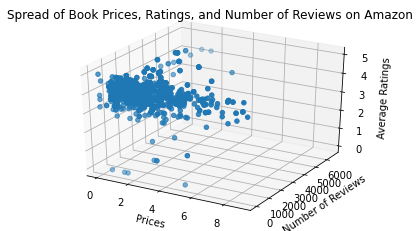

In [19]:
def plot_3D(df, company_name):    
    ax = plt.subplot(projection="3d")
    ax.scatter3D(df['price'],
                 df['reviews count'],
                 df['rating'])
    ax.set_xlabel('Prices')
    ax.set_ylabel('Number of Reviews')
    ax.set_zlabel('Average Ratings')
    ax.set_title(f'Spread of Book Prices, Ratings, and Number of Reviews on {company_name}')
    plt.show()
    
plot_3D(amzn_df, 'Amazon')

### Scatter Plot of Books on Flipkart

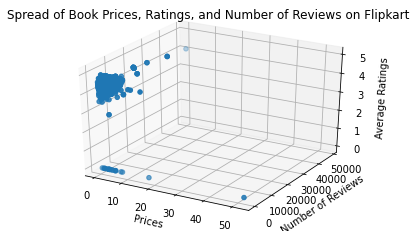

In [20]:
plot_3D(fp_df, 'Flipkart')

Looks like we have our work cut out for this!
Books on neither platform appear to have high covariance for the input features I decided to go with.
Nevertheless, this phenomenon is much more pronounced on Flipkart than Amazon. This suggest we may be on to some way to classify book listings as being sold on either of the two platforms!

## Distribution of Prices between Companies

Both DataFrames have the same 1,382 books listed. What is the range of prices on both sites?

In [21]:
def determine_range(df, col):
    return df[col].max() - df[col].min()

amzn_price_range = determine_range(amzn_df, 'price')
fp_price_range = determine_range(fp_df, 'price')
print(f'Price range on Amazon: ${amzn_price_range} USD')
print(f'Price range on Flipkart: ${fp_price_range} USD')

Price range on Amazon: $8.94 USD
Price range on Flipkart: $51.71 USD


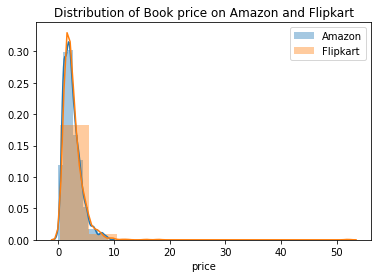

In [22]:
def plot_histogram(ls_1, ls_2, feature):
    sns.distplot(ls_1, hist=True, bins=10, kde=True, label='Amazon')
    sns.distplot(ls_2, hist=True, bins=10, kde=True, label='Flipkart')
    plt.legend()
    plt.title(f'Distribution of Book {feature} on Amazon and Flipkart')
    plt.show()
    
plot_histogram(amzn_df['price'], fp_df['price'], 'price')

### Uh oh, we have outliers!
This distribution is hard to bin, due to what seems to be the presence of outliers. How about we confirm that, using a boxplot:

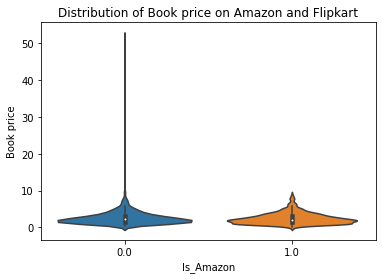

In [23]:
def make_boxplot(data, feature):
    fig, ax = plt.subplots()
    sns.violinplot(x="Is_Amazon", y=feature, data=data)
    plt.title(f'Distribution of Book {feature} on Amazon and Flipkart')
    ax.set_ylabel(f"Book {feature}")
    plt.show()
    
make_boxplot(all_books_mixed, 'price')

**Oh wow!** Amazon has much more outliers than Flipkart. How about we replot the PDF without those? 

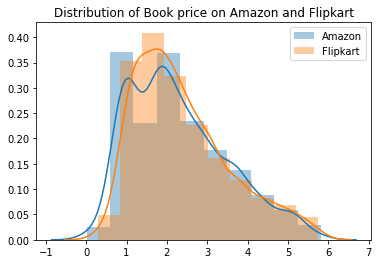

In [24]:
def find_remove_outlier_iqr(data_sample):
    """Removes outliers from a data_sample (array-like object) based on interquartile range.
       Credit for implementation goes to Ian Birnam, at
       https://github.com/UPstartDeveloper/DS-1.1-Data-Analysis/blob/master/Notebooks/Outlier_Correlation_StatisticalAnalysis.ipynb

    """
    # calculate interquartile range
    q25, q75 = np.percentile(data_sample, 25), np.percentile(data_sample, 75)
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    # identify outliers
    outliers = [x for x in data_sample if x < lower or x > upper]
    # remove outliers
    outliers_removed = [x for x in data_sample if x > lower and x < upper]
    return outliers_removed

def replot_histogram(df1, df2, feature):
    '''Remove outliers from the list of values for a feature across two DataFrames,
       and then plots their PDF'''
    # removing the outliers
    amzn_no_outliers = find_remove_outlier_iqr(df1[feature])
    fp_no_outliers = find_remove_outlier_iqr(df2[feature])
    # replotting the histogram
    plot_histogram(amzn_no_outliers, fp_no_outliers, feature)
    
replot_histogram(amzn_df, fp_df, 'price')

### Interesting!
For the most part book prices seem to fall into the same distribution on both marketplaces. However, Flipkart seem to have a higher mean price than Amazon.

## Distribution of Ratings between Companies
First of all, let's make sure we know the range of ratings, rather than assuming it's 0-5 stars.

In [25]:
print(f"Highest book rating on Amazon: {amzn_df['rating'].max()}")
print(f"Lowest book rating on Amazon: {amzn_df['rating'].min()}")
print(f"Maximum book rating on Flipkart: {fp_df['rating'].max()}")
print(f"Maximum book rating on Flipkart: {fp_df['rating'].min()}")

Highest book rating on Amazon: 5.0
Lowest book rating on Amazon: 0.0
Maximum book rating on Flipkart: 5.0
Maximum book rating on Flipkart: 0.0


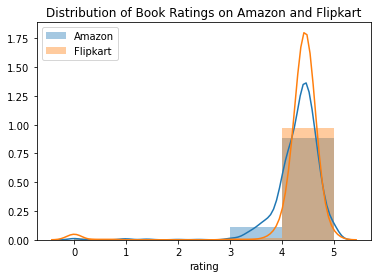

In [26]:
sns.distplot(amzn_df['rating'] , hist=True, bins=5, kde=True, label='Amazon')
sns.distplot(fp_df['rating'], hist=True, bins=5, kde=True, label='Flipkart')
plt.legend()
plt.title('Distribution of Book Ratings on Amazon and Flipkart')
plt.show()

Like prices, Flipkart book ratings appears to have a higher mean their Amazonian counterparts. As well, then are outliers to account for like before.

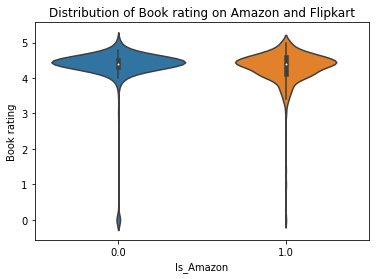

In [27]:
# plotting the boxplots of book ratings for both companies
make_boxplot(all_books_mixed, 'rating')

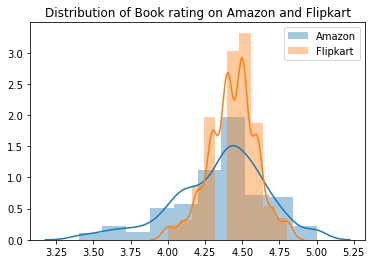

In [28]:
# Replot the Histogram, after Removing Outliers
replot_histogram(amzn_df, fp_df, 'rating')

### Upon Closer Inspection...
This gives a much better look! Like before we are able to see books on Flipkart tend to get a higher mean rating, than books of the *same title*, being sold on Amazon. We can also see there's an entire rating range (around 4.3-4.5) than Flipkart doesn't even have samples for, but which Amazon does.

## Distribution of Review Counts between Companies

In [29]:
def determine_range(df, col):
    return df[col].max() - df[col].min()

amzn_rcount_range = determine_range(amzn_df, 'reviews count')
fp_rcount_range = determine_range(fp_df, 'reviews count')
print(f'Range of review counts on Amazon: {amzn_rcount_range}')
print(f'Range of review counts on Flipkart: {fp_rcount_range}')

Range of review counts on Amazon: 6566.0
Range of review counts on Flipkart: 48324.0


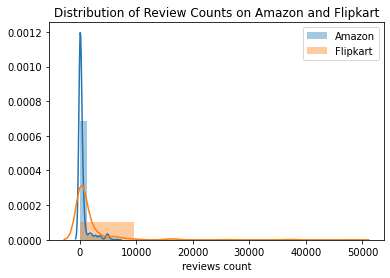

In [30]:
sns.distplot(amzn_df['reviews count'] , hist=True, bins=5, kde=True, label='Amazon')
sns.distplot(fp_df['reviews count'], hist=True, bins=5, kde=True, label='Flipkart')
plt.legend()
plt.title('Distribution of Review Counts on Amazon and Flipkart')
plt.show()

The pattern continues! Once again, Amazon shows off the stability of its platform, showing a much less variance than Flipkart does for the same statistic, regardless of the fact we are comparing the same books on both platforms. 

Before moving ahead let's zoom in on this distribution as well, by removing outliers and replotting the histogram! This will help ensure we are not losing too much information due to the presence of outliers.

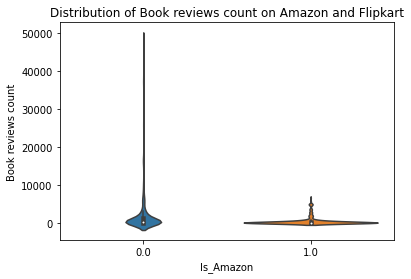

In [31]:
# plotting the boxplots of numberso of reviews for both companies
make_boxplot(all_books_mixed, 'reviews count')

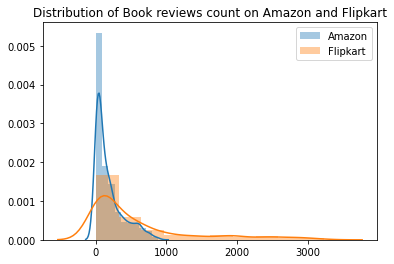

In [32]:
# Replot the Histogram, after Removing Outliers
replot_histogram(amzn_df, fp_df, 'reviews count')

Not much appears to have changed on this replotted histogram! Much of the same distribution is still observed, compared to when outliers were included.

At this point, is unclear from which of the two DataFrames that the outliers have been removed from. Let's be sure to check on that! If the lengths are still the same, then we can safely modify the combined DataFrame, and continue in this exploration.

In [33]:
if len(amzn_df.all().iloc[:]) == len(fp_df.all().iloc[:]):
    print('Classes are still balanced!')
    
# reinitializing the combined dfs
all_books_stacked = collect_rows(amzn_df, fp_df, True)
all_books_mixed = collect_rows(amzn_df, fp_df, False)

Classes are still balanced!


## Correlation Heatmap
How much correlation do price, rating, and review count have with our target, the company class?
How much multicolinearity do they have with each other?

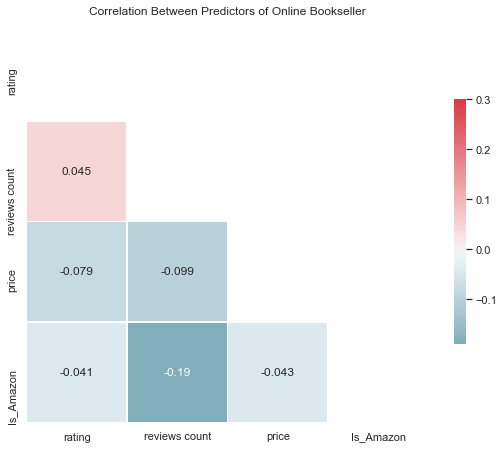

In [34]:
def make_heatmap(df, map_title):
    """Plots the diagonal correlation matrix of a dataset using Seaborn.
       Credit to the Seaborn Documentation for inspiring this cell:
       https://seaborn.pydata.org/examples/many_pairwise_correlations.html
       
       Parameters:
       df(pandas.DataFrame): encapsulates the dataset being used to make heatmap.
       map_title(str): the title for the heatmap
    
    """
    sns.set(style="white")
    # Compute the correlation matrix
    corr = df.corr()
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(9, 9))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
    plt.title(map_title)
    plt.show()
    
make_heatmap(all_books_mixed, 'Correlation Between Predictors of Online Bookseller')

This highlights an important notion: the correlation between 'reviews count' and 'rating' suggests that due to greater public satisfaction, the books that have a high number of reviews also correlate to having a higher rating. 


Before going any further it would be useful to normalize the dataset so that all the values are on the same scale, whereas currently - the values for 'reviews count' tend to be much higher than the other numerical columns.

# Preparing the Data for ML

## Splitting into Training and Testing

In [35]:
def split_scale_data(df, features, target_var):
    """Separate the data into inputs and outputs, as well as training and testing data.
    
    """
    # split the data
    X = df[features]
    y = df[target_var]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    return X_train, X_test, y_train, y_test

features = ['price', 'reviews count', 'rating']
target = 'Is_Amazon'
X_train, X_test, y_train, y_test = split_scale_data(all_books_mixed, features, target)

## Applying Standard Scaling

In [36]:
s_scaler = StandardScaler()
X_train_standard_scaled = s_scaler.fit_transform(X_train)
X_test_standard_scaled = s_scaler.transform(X_test)

## Applying MinMax Scaling

In [37]:
mm_scaler = MinMaxScaler()
X_train_mm_scaled = mm_scaler.fit_transform(X_train)
X_test_mm_scaled = mm_scaler.transform(X_test)

## Performing PCA

### Reducing to Principal Components

In [38]:
def apply_pca(data, num_components, is_scaled):
    '''Get a certain number of principal components for a dataset. Prints the explained variance ratios.'''
    # PCA computation using sklearn
    pca = PCA(n_components=num_components)
    data_reduced = pca.fit_transform(data)
    # determine if to print 'Scaled' or not
    if is_scaled is True:
        scale = 'Scaled'
    else:
        scale = 'Un-scaled'
    # Display resulting explained variance
    print(f'Variance Retained using PCA on {scale} Training Data, with {num_components} Components')
    print(pca.explained_variance_) 
    print(pca.explained_variance_ratio_)
    ratio = pca.explained_variance_ratio_.cumsum()
    print(ratio)
    print('---------------------------------------')
    
    return pca, data_reduced
    
apply_pca(X_train_standard_scaled, 1, True)
apply_pca(X_train, 1, False)
apply_pca(X_train_standard_scaled, 2, True)
pca, X_train_reduced = apply_pca(X_train, 2, False)

Variance Retained using PCA on Scaled Training Data, with 1 Components
[1.17782776]
[0.39241986]
[0.39241986]
---------------------------------------
Variance Retained using PCA on Un-scaled Training Data, with 1 Components
[7494118.76900407]
[0.99999947]
[0.99999947]
---------------------------------------
Variance Retained using PCA on Scaled Training Data, with 2 Components
[1.17782776 0.94799806]
[0.39241986 0.31584692]
[0.39241986 0.70826678]
---------------------------------------
Variance Retained using PCA on Un-scaled Training Data, with 2 Components
[7.49411877e+06 3.68557108e+00]
[9.99999472e-01 4.91794865e-07]
[0.99999947 0.99999996]
---------------------------------------


### Correlation of Principal Components

#### Training Data

In [39]:
def pca_corr(components):
    '''Prints the correlation seen for a list of two principal components.'''
    print('Correlation of PCA Components:')
    print(pearsonr(components[:, 0], components[:, 1]))
    
pca_corr(X_train_reduced)

Correlation of PCA Components:
(5.025819170556556e-16, 1.0000000000010378)


#### Testing Data

In [40]:
# do the same for testing data
X_test_reduced = pca.transform(X_test)
pca_corr(X_test_reduced)

Correlation of PCA Components:
(0.09834531279239006, 0.009687627262559503)


### Visualization of Data After PCA

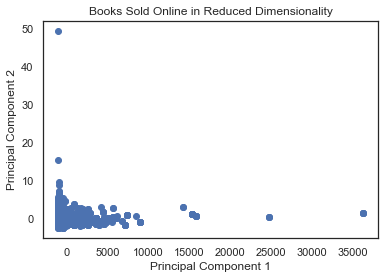

In [41]:
fig, ax = plt.subplots()
plt.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1],)
plt.title('Books Sold Online in Reduced Dimensionality')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
plt.show()

### Scaling Principal Components
Performing PCA on unscaled data with 2 principal components gave us the best explained variance. However, using this form of reduced data will lead to other problems in throwing off the bias of the classifier model, since the scales are thrown off (as you can see below).

Therefore, it makes sense to now scale the reduced data, before applying it to the machine learning models. Like before, both Standard and MinMax Scaling will be used.

In [42]:
## Standard Scaling after PCA
s_scaler_pca = StandardScaler()  # separate instance just to scale this version of the data
X_train_reduced_s_scaled = s_scaler_pca.fit_transform(X_train_reduced)
X_test_reduced_s_scaled = s_scaler_pca.transform(X_test_reduced)

## MinMax Scaling after PCA
mm_scaler_pca = MinMaxScaler()
X_train_reduced_mm_scaled = mm_scaler_pca.fit_transform(X_train_reduced)
X_test_reduced_mm_scaled = mm_scaler_pca.transform(X_test_reduced)

# Implementation of Different Classifer Models

## Support Vector Machine

### Grid Search

In [43]:
def svc_param_selection(X, y, nfolds, kernel_type):
    """Return the optimal hyperparameters to use on a Support Vector Machine classifier.
       Credit to Milad Toutounchian for the following implementation, found at:
       https://github.com/Make-School-Courses/DS-2.1-Machine-Learning/blob/master/Notebooks/simple_Model_Evaluation.ipynb
       
       Parameters:
       X(array-like): features of the dataset that are input to the model to make its classification
       y(array-like): feature of the dataset being targeted for classification
       nfolds(int): specificies the number of divisions to make in the data, as a cross validation strategy
       kernel_type(str): the type of kernel for the SVC we are optimizing
       
       Returns: dict: param settings that gave the best result
    """
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    # only use gammas if using for Radial Basis Function
    if kernel_type == 'rbf':
        param_grid = {'C': Cs, 'gamma' : gammas}
    else:
        param_grid = {'C': Cs}
    grid_search = GridSearchCV(SVC(kernel=kernel_type), param_grid, cv=nfolds, n_jobs=3, scoring='accuracy')
    grid_search.fit(X, y)
    return grid_search.best_params_


# collecting all the best hyperparams for SVM in one
kernels = ['linear', 'poly', 'rbf']
s_scaled_kernel_params = {}
X = all_books_mixed[features]
X_standard_scaled = s_scaler.transform(X)
y = all_books_mixed['Is_Amazon']
for kernel in kernels:
    s_scaled_kernel_params[kernel] = svc_param_selection(X_standard_scaled, y, 5, kernel)

In [44]:
s_scaled_kernel_params

{'linear': {'C': 10}, 'poly': {'C': 10}, 'rbf': {'C': 10, 'gamma': 1}}

### Would the values for these hyperparameters change, if we changed the type of scaling used?

In [45]:
mm_scaled_kernel_params = {}
X_mm_scaled = mm_scaler.transform(X)
# iterate over the same three kernels
for kernel in kernels:
    mm_scaled_kernel_params[kernel] = svc_param_selection(X_standard_scaled, y, 5, kernel)

In [46]:
mm_scaled_kernel_params

{'linear': {'C': 10}, 'poly': {'C': 10}, 'rbf': {'C': 10, 'gamma': 1}}

### What if the PCA components were used?

In [47]:
# first try with Standard Scaled-PCA data
pca_s_scaled_kernel_params = {}
for kernel in kernels:
    pca_s_scaled_kernel_params[kernel] = svc_param_selection(X_train_reduced_s_scaled, y_train, 5, kernel)
pca_s_scaled_kernel_params

{'linear': {'C': 10}, 'poly': {'C': 10}, 'rbf': {'C': 10, 'gamma': 1}}

It apppears that the optimal values for the hyperparameters of this model are set in stone. This makes sense, as regardless of the type of data we use (standard/minmax scaled, reduced dimensionality or not), we are not changing the values of y_train. That is to say, all of these forms of data are just different paths taking us to the same destination. With that in mind, we may investigate which type of kernel will be best for the SVM to classify our data.

### Which Kernel Performs the Best, on Standard Scaled Data? (Confusion Matrix)

In [48]:
def calculate_rate(numerator, denominator):
        '''Return the percent value for a statistical formula.'''
        return round(numerator/denominator, 2) * 100

def print_confusion_metrics(cm):
    '''Prints metrics of the model, derived from the confusion matrix.'''
    TN, FP, FN, TP = cm.ravel()
    # calculate the metrics
    accuracy, precision, recall = (
        calculate_rate(TP + TN, TP + TN + FP + FN),
        calculate_rate(TP, TP + FP),
        calculate_rate(TP, TP + FN)
    )
    f1 = round((2 * precision * recall)/(float(precision + recall))/100, 4)
    # display the results
    print('CONFUSION MATRIX METRICS')
    print(f'Accuracy: {accuracy}%')
    print(f'Precision: {precision}%')
    print(f'Recall: {recall}%')
    print(f'F1-Score: {f1}')
    return None
   
def run_svm_and_evaluate(kernel_type, X_train, y_train, X_test, y_test):
    """Evaluate the Support Vector Machine performance on each kernel, with optimized hyperparams 
       and same data.
       
       Returns: None
       
    """
    # initialize variables to defaults in sklearn, then switch to optimized values
    gamma_value = 'scale' 
    if kernel_type == 'rbf':
        gamma_value = s_scaled_kernel_params[kernel_type]['gamma']
    C_value =  s_scaled_kernel_params[kernel_type]['C']
     # instantiate the Support Vector Machine, with the optimized hyperparams
    svm = SVC(kernel=kernel_type, C=C_value, gamma=gamma_value)
    # train the model, then test it!
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    # produce results using the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print_confusion_metrics(cm)
    # return the model
    return svm

def show_svm_results_different_kernels(kernels, X_train, y_train, X_test, y_test):
    """Tries the SVM model out for linear, polynomial, and rbf kernel, for one 
       kind of data.
       
    """
    standard_svms = list()
    for kernel in kernels:
        print(f'Performance of {kernel} kernel')
        svm = run_svm_and_evaluate(kernel, X_train, y_train, X_test, y_test)
        standard_svms.append(svm)
        print('\n')
    return standard_svms

standard_svms = show_svm_results_different_kernels(kernels, X_train_standard_scaled, 
                                                   y_train, X_test_standard_scaled, y_test)

Performance of linear kernel
CONFUSION MATRIX METRICS
Accuracy: 57.99999999999999%
Precision: 56.00000000000001%
Recall: 91.0%
F1-Score: 0.6933


Performance of poly kernel
CONFUSION MATRIX METRICS
Accuracy: 61.0%
Precision: 57.99999999999999%
Recall: 91.0%
F1-Score: 0.7085


Performance of rbf kernel
CONFUSION MATRIX METRICS
Accuracy: 71.0%
Precision: 73.0%
Recall: 72.0%
F1-Score: 0.725




### Evaluating the SVM again, with MinMax Scaled Data

In [49]:
mm_svms = show_svm_results_different_kernels(kernels, X_train_mm_scaled, 
                                             y_train, X_test_mm_scaled, y_test) 

Performance of linear kernel
CONFUSION MATRIX METRICS
Accuracy: 57.99999999999999%
Precision: 56.00000000000001%
Recall: 91.0%
F1-Score: 0.6933


Performance of poly kernel
CONFUSION MATRIX METRICS
Accuracy: 59.0%
Precision: 56.99999999999999%
Recall: 91.0%
F1-Score: 0.7009


Performance of rbf kernel
CONFUSION MATRIX METRICS
Accuracy: 59.0%
Precision: 56.99999999999999%
Recall: 82.0%
F1-Score: 0.6725




### Evaluating the SVM on 2 Principal Components

#### Standard Scaling

In [50]:
pca_s_svms = show_svm_results_different_kernels(kernels, X_train_reduced_s_scaled, 
                                                 y_train, X_test_reduced_s_scaled, y_test) 

Performance of linear kernel
CONFUSION MATRIX METRICS
Accuracy: 57.99999999999999%
Precision: 56.00000000000001%
Recall: 91.0%
F1-Score: 0.6933


Performance of poly kernel
CONFUSION MATRIX METRICS
Accuracy: 57.99999999999999%
Precision: 56.00000000000001%
Recall: 99.0%
F1-Score: 0.7154


Performance of rbf kernel
CONFUSION MATRIX METRICS
Accuracy: 65.0%
Precision: 63.0%
Recall: 82.0%
F1-Score: 0.7126




#### MinMax Scaling

In [51]:
pca_mm_svms = show_svm_results_different_kernels(kernels, X_train_reduced_mm_scaled, 
                                                 y_train, X_test_reduced_mm_scaled, y_test) 

Performance of linear kernel
CONFUSION MATRIX METRICS
Accuracy: 57.99999999999999%
Precision: 56.00000000000001%
Recall: 91.0%
F1-Score: 0.6933


Performance of poly kernel
CONFUSION MATRIX METRICS
Accuracy: 61.0%
Precision: 56.99999999999999%
Recall: 95.0%
F1-Score: 0.7125


Performance of rbf kernel
CONFUSION MATRIX METRICS
Accuracy: 57.99999999999999%
Precision: 56.00000000000001%
Recall: 91.0%
F1-Score: 0.6933




**Conclusion: And the Winner is the Polynomial Kernel!**

In our use case, it makes sense to optimize for a "happy medium" between having both high scores for precision and recall rather than just recall, because deciding where to buy books is a relatively low-risk classification problem, so the false negatives are not to be a major issue. As a result, the most important metric to look at derived from our confusion matrix is the F1-score, which factors in both the precision and recall.

The other fact to bear in mind is that there is very little variance in this dataset, as seen earlier. As a result it becomes noteworthy if a certain kernel helps us increase the recall, because that means the model is able to handle the false negatives (books that were classified as being on Flipkart, but were really being sold on Amazon). 

For this reason the polynomial kernel stands out. For both using standard and minmax scaling algorithms, the support vector machine using the polynomial kernel had the best combination of both high F1-Score and Recall. 

### Is the SVM Model Overfitting?
Once we switched to using PCA, the model improved it's scores alot, particularly in Recall. Have we caused the model to become too specialized to the data?
Let's visualize the hyperplane to get an idea!

We'll take a look at each of the Support Vector Machines trained on principal components and standard scaled data, because they performed the best overall and can be visualized in 3D and 2D. 

First, the 3D scatter plot will give us a rough idea of the relative location of the hyperplane. It is shown twice, once for both the training and test data:

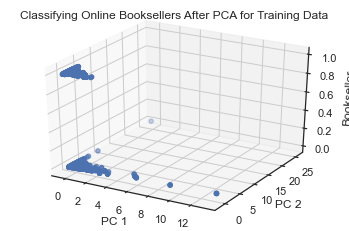

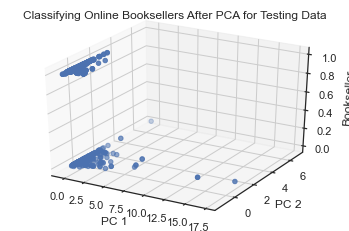

In [52]:
def plot_svm_3D(X, y, data_split): 
    """Plot the three dimensions of bookstore data using principal components.
       
       Parameters:
       X (array-like): the features of the data samples, reduced in dimensionality
       y (array-like): the label for those data samples
       data_split (str): specifies whether X and y came from the training or testing set
    """
    # separate into the different dimensions for the plot
    X0, X1, y = X[:, 0],  X[:, 1], y
    # make the plot
    ax = plt.subplot(projection="3d")
    ax.scatter3D(X0, X1, y)
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_zlabel('Bookseller')
    ax.set_title(f'Classifying Online Booksellers After PCA for {data_split}')
    plt.show()
    
plot_svm_3D(X_train_reduced_s_scaled, y_train, "Training Data")
plot_svm_3D(X_test_reduced_s_scaled, y_test, "Testing Data")

From here we can induce that the smaller cluster above is for the 'Amazon' classification, since they are the less varying cluster, as hinted at before during our data analysis.

Here's how well the SVM did at drawing a decision boundary between these two classes:

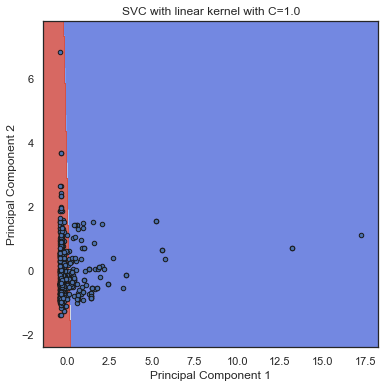

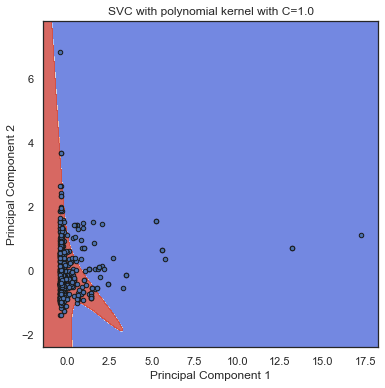

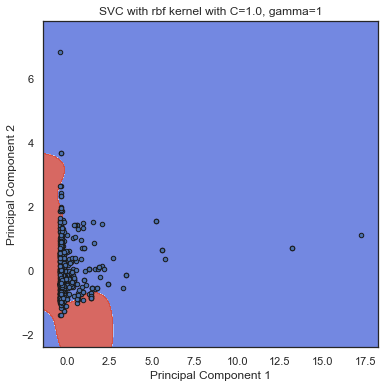

In [53]:
# The following is based off the Sklearn documentation, huge credit is due to: 
# https://scikit-learn.org/stable/auto_examples/svm/plot_iris_svc.html
from sklearn.svm import LinearSVC
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in grid.

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def plot_svm_2D(titles, svms, index):
    '''Shows the plot of our SVM in color.'''
    # Set-up 2x2 grid for plotting.
    fig, ax = plt.subplots(figsize=(6, 6))
    # plot the samples and decision boundary
    X0, X1 = X_test_reduced_s_scaled[:, 0], X_test_reduced_s_scaled[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    clf, title = pca_s_svms[index], titles[index]
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8),
    ax.scatter(X0, X1, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    # make the plot more readable
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    plt.subplots_adjust(hspace=.5)
    ax.set_title(title)

    plt.show()
    return
    
titles = [
    ('SVC with linear kernel with C=1.0'),
    ('SVC with polynomial kernel with C=1.0'),
    ('SVC with rbf kernel with C=1.0, gamma=1')
]
# plot all three SVM's trained on PCA components, scaled with standard scaling
for i in range(len(titles)):
    plot_svm_2D(titles, pca_s_svms, i)

**Conclusion: Was the Model Overfitting?**

Although the Support Vector Machine model we generated on the principal components of the dataset is drawing extremely specialized decision boundaries between Amazon and Flipkart, it is arguably still not overfitting. It is important to note that is very little variance in this dataset, for both classes and especially for Amazon. Therefore while some of the boundaries drawn here are too specialized (looking at you RBF kernel), on the other hand there are other SVM's (namely the linear kernel that arguably do a reasonable job of balancing the tradeoffs between bias and variance for the Amazonian samples.

## Logistic Regression
What if we want to know the probabilities behind the classifications of the model? It's time to use Logistic Regression!

### Results with Standard Scaled Data

In [54]:
def make_logreg(X_train, y_train, X_test, y_test):
    '''Go through the process of training and testing a Logistic Regression model.'''
    # Creating the Model
    logreg = LogisticRegression(random_state=0, solver="lbfgs")
    logreg.fit(X_train, y_train)
    # Testing the Model
    y_pred = logreg.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print_confusion_metrics(cm)
    return y_pred, logreg
    
y_pred, logreg1 = make_logreg(X_train_standard_scaled, y_train, X_test_standard_scaled, y_test)

CONFUSION MATRIX METRICS
Accuracy: 62.0%
Precision: 60.0%
Recall: 84.0%
F1-Score: 0.7


### Results with MinMax-Scaled Data

In [55]:
y_pred, logreg2 = make_logreg(X_train_mm_scaled, y_train, X_test_mm_scaled, y_test)

CONFUSION MATRIX METRICS
Accuracy: 62.0%
Precision: 59.0%
Recall: 84.0%
F1-Score: 0.6931


**Conclusion: MinMax vs Standard Scaling**

There appears to be no significant difference between what kind of algorithm is used to scale the data, for this dataset, as it relates to the performance of the logistic regression model. As seen in the printouts, the resulting values of the model precision and F1-score were only slightly worse, when trained on MinMax-scaled data. This may be due to the fact that MinMax reduced the range of our values between 0-1, while in Standard Scaling lets the range go between -1 and +1. Since we have so little variation in the dataset, it could be that the greater range in the normal  affords the model more "room" to allow the values of a sample as falling into one class or the other.

### Results with PCA
Now that the data is in 2 dimensions a visualization will be included, in order to compare and contrast where and how the model may perform on either version of the data.

####  Standard Scaled Data

In [56]:
y_pred, logreg3 = make_logreg(X_train_reduced_s_scaled, y_train, X_test_reduced_s_scaled, y_test)

CONFUSION MATRIX METRICS
Accuracy: 62.0%
Precision: 60.0%
Recall: 85.0%
F1-Score: 0.7034


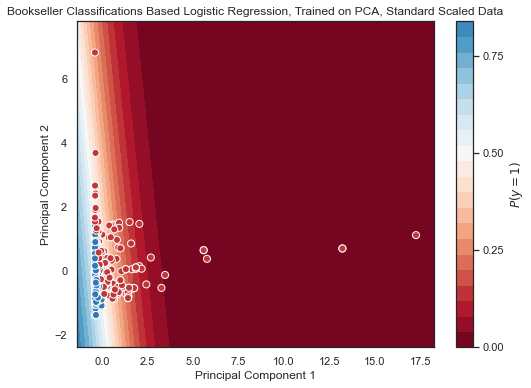

In [57]:
def plot_logreg(logreg, X, y, scaling_type):
    """Shows the plot of Logistic Regression model in color.
    
       Credit to this Stack Overflow answer for helping me understand the
       way to add the probability key to the right:
       https://stackoverflow.com/questions/28256058/plotting-decision-boundary-of-logistic-regression
    
    """
    # set up plotting space
    sns.set(style="white")
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    grid = np.c_[xx.ravel(), yy.ravel()]
    # obtain the probabilities for the classifications
    probs = logreg3.predict_proba(grid)[:, 1].reshape(xx.shape)
    # plot the samples
    f, ax = plt.subplots(figsize=(8, 6))
    contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                          vmin=0, vmax=1)
    # add a color key to show which class each sample belongs to
    ax_c = f.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, .25, .5, .75, 1])
    ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
               cmap="RdBu", vmin=-.2, vmax=1.2,
               edgecolor="white", linewidth=1)
    # make the plot more readable
    plt.title(f'Bookseller Classifications Based Logistic Regression, Trained on PCA, {scaling_type} Data')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    plt.show()
    return

plot_logreg(logreg3, X_test_reduced_s_scaled, y_pred, "Standard Scaled")

####  MinMax Scaled Data

CONFUSION MATRIX METRICS
Accuracy: 62.0%
Precision: 59.0%
Recall: 86.0%
F1-Score: 0.6999


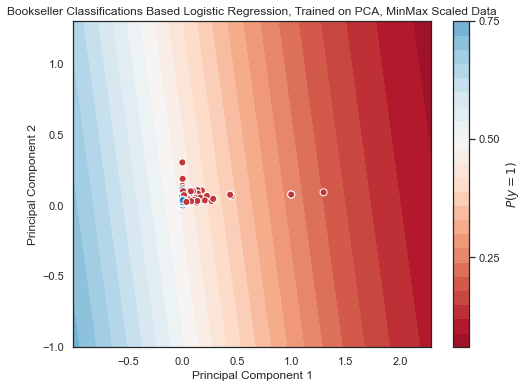

In [58]:
y_pred, logreg4 = make_logreg(X_train_reduced_mm_scaled, y_train, X_test_reduced_mm_scaled, y_test)
plot_logreg(logreg4, X_test_reduced_mm_scaled, y_pred, "MinMax Scaled")

**Conclusion: MinMax vs. Standard Scaling for Logistic Regression**

Overall, the Logistic Regression model performed the best (based upon the F1-score) when trained using the principal components of the dataset, which had been normalized using StandardScaler. Comparing the graphs of the Logistic Regression models above, it becomes that while the model trained on MinMax achieved a slightly greater recall percentage, the MinMax-trained model suffers from having the samples too bunched up together. This hardly allows for the model to make the best decision, based upon the variance of the dataset.

## K-Nearest Neighbors
Earlier we combined the DataFrames in two ways:
1. "Mixed" - such that books of the same title, but being sold on different sites, were next to each other
2. "Stacked" - such that all of Amazon's books were next to each other, and then all of Flipkart's books are listed

How will affect the performance of the K-Nearest Neighbors algorithm? And how will using unscaled/scaled data affect it?

NOTE: Below I chose to use only Standard Scaled-data for the tests involving scaled data, because for reasons explained above it has proven to be more useful than the MinMax algorithm for scaling this dataset.

### KNN without PCA
First, let's keep track of all our data in Python dictionaries.

There's four ways for us to run KNN on the dataset, using all 3 of our features. Then, we'll take a look at using KNN with the principal components of the data only.

In [59]:
# Data from Mixed df, unscaled
mixed_unscaled = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test
}

# Data from Mixed df, scaled
mixed_scaled = {
    'X_train': X_train_standard_scaled,
    'X_test': X_test_standard_scaled,
    'y_train': y_train,
    'y_test': y_test
}

# Data from Stacked df, unscaled - now we need to rerun train_test_split using the other df!
X_train_stacked, X_test_stacked, y_train_stacked, y_test_stacked = (
    split_scale_data(all_books_stacked, features, target)
)
stacked_unscaled = {
    'X_train': X_train_stacked,
    'X_test': X_test_stacked,
    'y_train': y_train_stacked,
    'y_test': y_test_stacked
}

# Data from Stacked df, scaled - now we reuse the standard scaling instance!
X_train_stacked_standard_scaled = s_scaler.fit_transform(X_train_stacked)
X_test_stakced_standard_scaled = s_scaler.transform(X_test_stacked)
stacked_scaled = {
    'X_train': X_train_stacked_standard_scaled,
    'X_test': X_test_stakced_standard_scaled,
    'y_train': y_train_stacked,
    'y_test': y_test_stacked
}

#### Test 1: Mixed Books, Unscaled Data

First, let's determine the optimal number of neighbors to use:

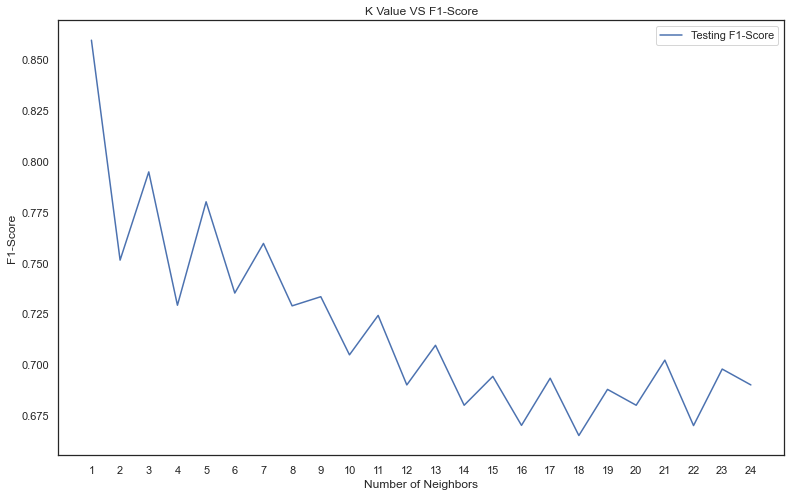

Best F1-Score is 0.8595 with K=1


In [60]:
def calculate_f1_score(y_test, y_pred):
    '''Calculates the confusion matrix, and then returns the F1-score.'''
    cm = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cm.ravel()
    precision, recall = (
        calculate_rate(TP, TP + FP),
        calculate_rate(TP, TP + FN)
    )
    f1 = round((2 * precision * recall)/(float(precision + recall))/100, 4)
    return f1
    
    
def determine_num_neighbors(X_train, y_train, X_test):
    """Plot the train and testing f1-score of KNN model, as K increases.
       Credit for this implementation goes to the Make School's DS 2.1
       classification tutorial:
       https://www.makeschool.com/academy/track/standalone/ds-2-1-classification-tutorial/kNN-classifier

    """
    neighbors = np.arange(1, 25)
    # train_accuracy, test_accuracy = list(), list()
    test_f1 = list()

    for iterator, kterator in enumerate(neighbors):
        knn = KNeighborsClassifier(n_neighbors=kterator)
        knn.fit(X_train, y_train)
        # train_accuracy.append(knn.score(X_train, y_train))
        # test_accuracy.append(knn.score(X_test, y_test))
        y_pred = knn.predict(X_test)
        test_f1.append(calculate_f1_score(y_test, y_pred))

    plt.figure(figsize=[13, 8])
    plt.plot(neighbors, test_f1, label="Testing F1-Score")
    # plt.plot(neighbors, train_accuracy, label="Training Accuracy")
    plt.legend()
    plt.title("K Value VS F1-Score")
    plt.xlabel("Number of Neighbors")
    plt.ylabel("F1-Score")
    plt.xticks(neighbors)
    plt.show()

    print("Best F1-Score is {} with K={}".format(np.max(test_f1), 1 + test_f1.index(np.max(test_f1))))

determine_num_neighbors(mixed_unscaled['X_train'],
                        mixed_unscaled['y_train'],
                        mixed_unscaled['X_test'])


In [61]:
def execute_knn(data, num_neighbors):
    '''Execute the KNN algorithm using sklearn.'''
    knn = KNeighborsClassifier(n_neighbors=num_neighbors)
    # make predictions
    knn.fit(data['X_train'], data['y_train'])
    # evaluate model performance
    y_pred = knn.predict(data['X_test'])
    cm = confusion_matrix(y_test, y_pred)
    print_confusion_metrics(cm)
    return knn

knn1 = execute_knn(mixed_unscaled, 1)

CONFUSION MATRIX METRICS
Accuracy: 86.0%
Precision: 88.0%
Recall: 84.0%
F1-Score: 0.8595


#### Test 2: Mixed Books, Standard Scaled Data
For the next test, K=1 once again.
It makes sense that the KNN algorithm has the best testing accuracy when K=1, in the mixed DataFrame. Adjacent samples in the mixed DataFrame have the same title and different classification. This means that for each sample, there is just one other neighbor that the algorithm needs to iterate over to, to have made all the comparisions useful for picking up trends in our data!

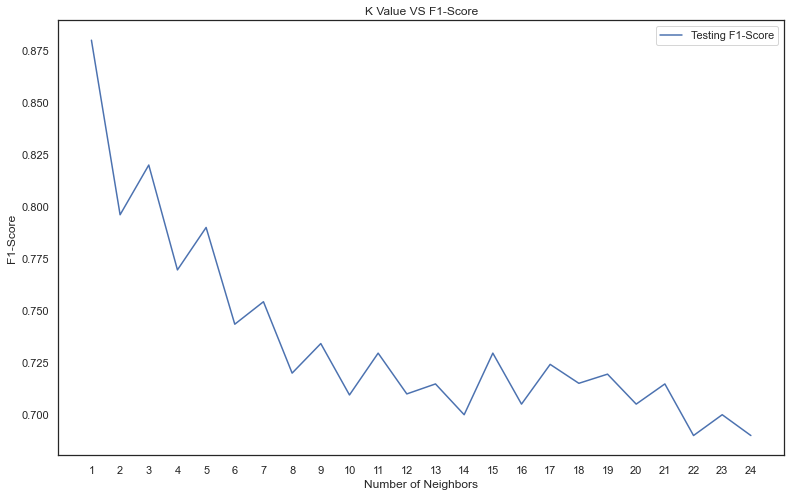

Best F1-Score is 0.8799 with K=1


In [62]:
determine_num_neighbors(mixed_scaled['X_train'],
                        mixed_scaled['y_train'],
                        mixed_scaled['X_test'])

In [63]:
knn2 = execute_knn(mixed_scaled, 1)

CONFUSION MATRIX METRICS
Accuracy: 88.0%
Precision: 89.0%
Recall: 87.0%
F1-Score: 0.8799


#### Test 3: Stacked Books, Unscaled Data

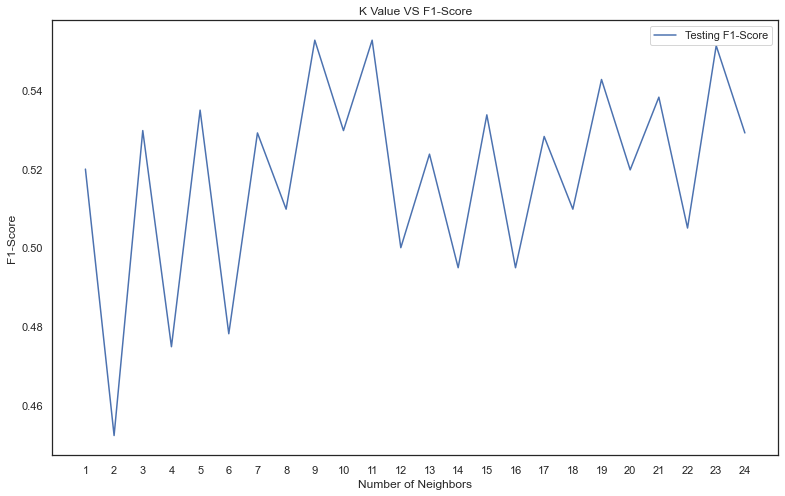

Best F1-Score is 0.5528 with K=9


In [64]:
determine_num_neighbors(stacked_unscaled['X_train'], 
                        stacked_unscaled['y_train'],
                        stacked_unscaled['X_test'])

In [65]:
knn3 = execute_knn(stacked_unscaled, 9)

CONFUSION MATRIX METRICS
Accuracy: 51.0%
Precision: 52.0%
Recall: 59.0%
F1-Score: 0.5528


#### Test 4: Stacked Books, Standard Scaled Data

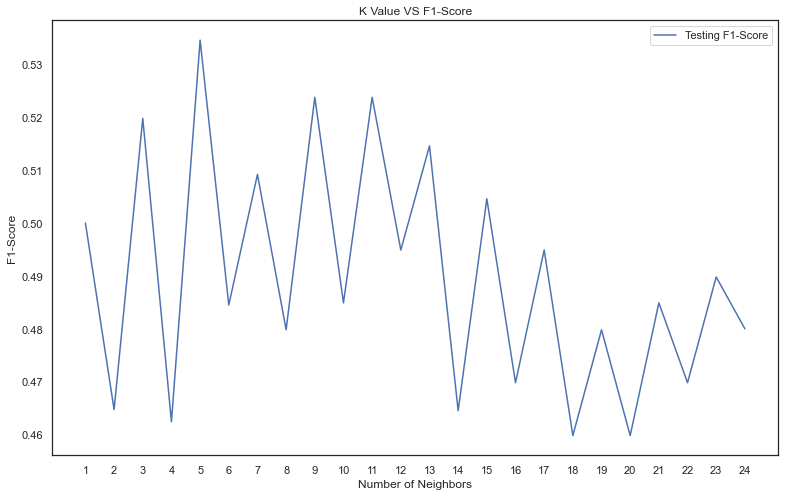

Best F1-Score is 0.5346 with K=5


In [66]:
determine_num_neighbors(stacked_scaled['X_train'], 
                        stacked_scaled['y_train'],
                        stacked_scaled['X_test'])

In [67]:
knn4 = execute_knn(stacked_scaled, 5)

CONFUSION MATRIX METRICS
Accuracy: 50.0%
Precision: 52.0%
Recall: 55.00000000000001%
F1-Score: 0.5346


**Conclusion: Mixed vs. Stacked**
    
Apparently, there is a substantial drop in model performance in KNN when the books are stacked.
That is to say the model becomes worse in terms of confusion matrix metrics, when all the books of one bookseller are listed separately from all the books of the other seller.

The optimal K values for the models using the "stacked" data were also much higher. This suggests that homogoenously ordering the books in the dataset by their bookseller did no help to improve the model, and added insult to injury by making the algorithm more inefficient. This is because when the books of same title yet different bookseller are not adjacent to each other, the model is not able to derive the variance and bias of the decision boundary as easily.

### KNN on Principal Components

In [68]:
# new dictionaries for the Principal components of the data
pca_s_scaled = {
    'X_train': X_train_reduced_s_scaled,
    'y_train': y_train,
    'X_test': X_test_reduced_s_scaled,
    'y_test': y_test
}

pca_mm_scaled = {
    'X_train': X_train_reduced_mm_scaled,
    'y_train': y_train,
    'X_test': X_test_reduced_mm_scaled,
    'y_test': y_test
}

#### Test 5: Components in a Normal Distribution
Brought to you by Standard Scaler.

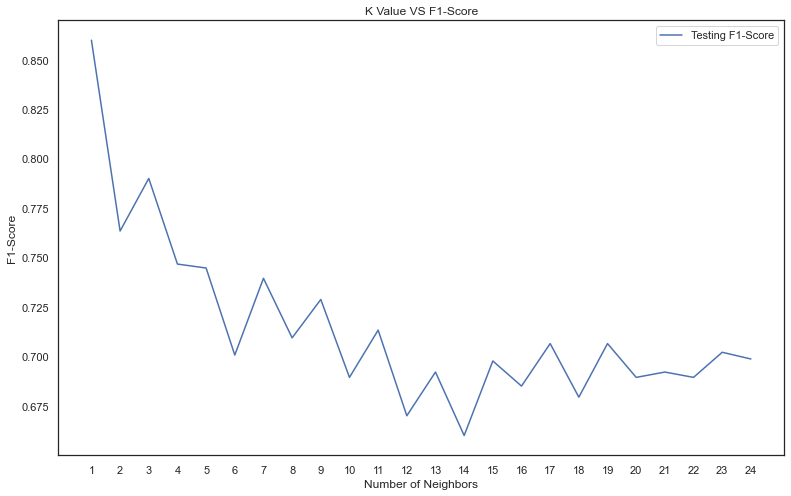

Best F1-Score is 0.8599 with K=1


In [69]:
# discover the optimal value of neighbors to check
determine_num_neighbors(pca_s_scaled['X_train'], 
                        pca_s_scaled['y_train'],
                        pca_s_scaled['X_test'])

Evaluation of the model:

In [70]:
knn5 = execute_knn(pca_s_scaled, 1)

CONFUSION MATRIX METRICS
Accuracy: 86.0%
Precision: 87.0%
Recall: 85.0%
F1-Score: 0.8599


### Visualization of the KNN Algorithm - A Definite Case of Overfitting
Shown for the version of the model ran on principal components, and then scaled using standard scaling.

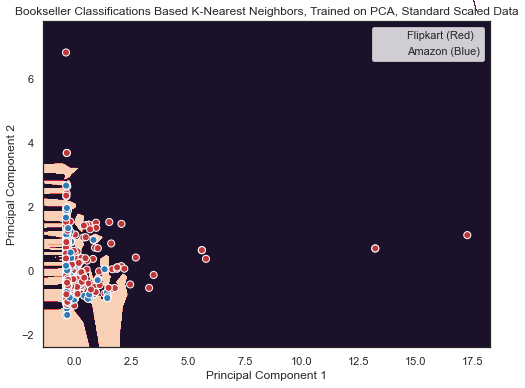

In [71]:
def plot_knn(knn, X, y, scaling_type):
    """Shows the plot of Logistic Regression model in color.
    
       Credit to this Stack Overflow answer for helping me understand the
       way to add the probability key to the right:
       https://stackoverflow.com/questions/28256058/plotting-decision-boundary-of-logistic-regression
    
    """
    # set up plotting space
    sns.set(style="white")
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    grid = np.c_[xx.ravel(), yy.ravel()]
    # plot the samples
    f, ax = plt.subplots(figsize=(8, 6))
    # make the decision boundary clear
    contour = plot_contours(ax, knn, xx, yy)
    # color code the points!
    ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
               cmap="RdBu", vmin=-.2, vmax=1.2,
               edgecolor="white", linewidth=1)
    # make the plot more readable
    plt.title(f'Bookseller Classifications Based K-Nearest Neighbors, Trained on PCA, {scaling_type} Data')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    # add a legend 
    plt.legend(["Flipkart (Red)", "Amazon (Blue)"])
    plt.show()
    return

X_test = pca_s_scaled['X_test']
y_pred = knn5.predict(X_test)
plot_knn(knn5, X_test, y_pred, 'Standard Scaled')

#### Test 6: Components in a 0-1 Range
Brought to you by MinMax Scaler.

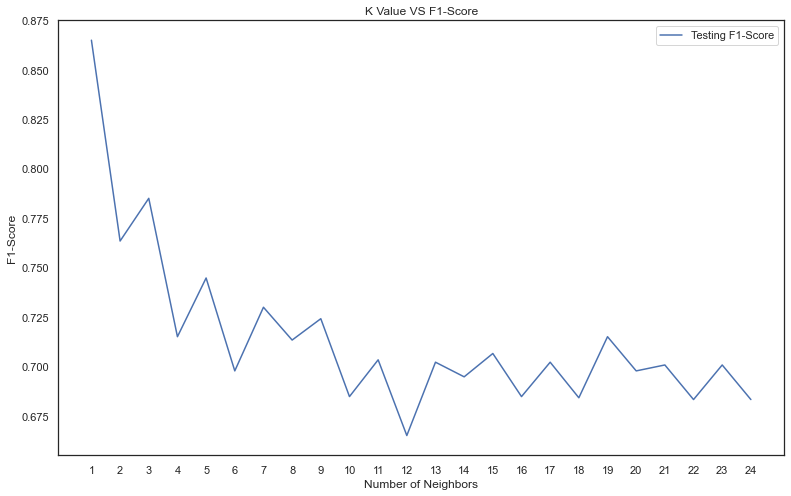

Best F1-Score is 0.865 with K=1


In [72]:
determine_num_neighbors(pca_mm_scaled['X_train'], 
                        pca_mm_scaled['y_train'],
                        pca_mm_scaled['X_test'])

In [73]:
knn6 = execute_knn(pca_mm_scaled, 1)

CONFUSION MATRIX METRICS
Accuracy: 86.0%
Precision: 87.0%
Recall: 86.0%
F1-Score: 0.865


### Visualization of the KNN Algorithm:
Shown for the version of the model ran on principal components, and then scaled using minmax scaling.

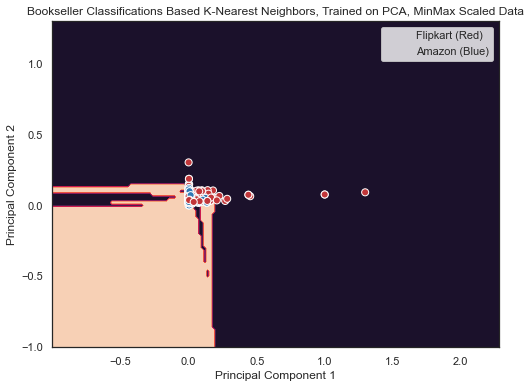

In [74]:
X_test = pca_mm_scaled['X_test']
y_pred = knn6.predict(X_test)
plot_knn(knn6, X_test, y_pred, 'MinMax Scaled')

**Final Conclusion**

Overall, the best results from these tests on K-Nearest Neighbors came from the DataFrame where the data samples from the two companies alternated each other. Using data that had been ordered this way also made the algorithm more efficient, as the mode of optimal K-values for all the models trained on mixed data were 1. PCA did not produce the best model for the KNN algorithm, instead the model with the best F1-score was trained on all 3 features, from the mixed DataFrame, and having been scaled to a normal distribution.

However, it is important to keep in mind that from the two plots of the K-Nearest Neighbors algorithm above on the principal components of the dataset, we can inductively reason that the best model for KNN is overfitted to the data. This might be due to the low values for K, causing the decision boundary to become overly specialized.

## Decision Tree Classifier
This model is a popular choice for helping to inform the decisions of business stakeholders. It uses a tree like data structure to classify inputs, based on maximizing the information gain it derives between the features.

To begin, we need to engineer the features of the data so that they store categorical values.

**How Will We Do This?**
From the visualizations created above, there are several qualitative assessments we can use to distinguish between the books sold on Amazon, versus Flipkart:

- Book prices on Amazon have a lower variance than on Flipkart (as measured by standard deviation)
- The same applies for book ratings, and the counts of book reviews

To support this claim, let's build a function to place all the features of the dataset side by side one another, and see how commonly used statistics differ between books of the two classes:

In [75]:
def print_book_stats(company_type, df):
    '''Describe the stats for books sold by one company, for each of the dataset features.'''
    if company_type == 1:
        company_name = 'Amazon'
    else:  # company_type = 0
        company_name = 'Flipkart'
    print(f'Statistics for Books Sold on {company_name}')
    # to make life easier, let's use the principal components of the data for these measurements
    return df[df['Is_Amazon'] == company_type].describe()
    
# to make life easier, let's use the principal components of the data for these measurements
amzn_stats = print_book_stats(1, all_books_mixed)
amzn_stats

Statistics for Books Sold on Amazon


,rating,reviews count,price,Is_Amazon
count,1382.000000,1382.000000,1382.000000,1382.0
mean,4.311505,490.724313,2.475166,1.0
std,0.456450,1015.285750,1.513666,0.0
min,0.000000,0.000000,0.010000,1.0
25%,4.100000,40.000000,1.352500,1.0
50%,4.400000,135.500000,2.130000,1.0
75%,4.600000,391.000000,3.200000,1.0
max,5.000000,6566.000000,8.950000,1.0


In [76]:
fp_stats = print_book_stats(0, all_books_mixed)
fp_stats

Statistics for Books Sold on Flipkart


,rating,reviews count,price,Is_Amazon
count,1382.000000,1382.000000,1382.000000,1382.0
mean,4.355572,1580.679450,2.634363,0.0
std,0.609942,3884.373654,2.101640,0.0
min,0.000000,0.000000,0.300000,0.0
25%,4.300000,86.250000,1.492500,0.0
50%,4.400000,354.500000,2.200000,0.0
75%,4.500000,1344.000000,3.200000,0.0
max,5.000000,48324.000000,52.010000,0.0


Cool! From this data, we can hypothesize that the *distance* between the value any given book sample has for one of it's features, and the *mean value for Amazon books for that feature*, can give us a way to indicate which binary value to encode it as!

For example, if we see a book whose value for the 'rating' column falls within 1 standard deviation of the mean for Amazon book ratings, then we'll encode it as a 1. Otherwise, we'll encode it as a 0, because we know then there's a more considerable chance it is being sold on Flipkart. 

Note this approach will not be perfect, as it does not account for the greater variance seen within the features for books sold on Flipkart. For instance, a book being sold on Flipkart with a rating far closer to the Amazon mean than Flipkart mean will be misclassified using this algorithm.

However this approach will be used for now as it does show some promise, without the worry of creating overfitting (which we could easily do if we naviely encode the features of books to be the same as their label, for instance).

In [77]:
def mark_distance_from_mean(feature, value, stats):
    """Check how close the rating falls to the Amazon mean.
       Returns the proper value to encode it.
    
    """
    amzn_mean, amzn_std = stats[feature][1], stats[feature][2]
    if abs(float(value) - float(amzn_mean)) < amzn_std:
        return 1
    else: # encode to the Flipkart value
        return 0

def convert_features(df, features, stats):
    '''Binary encodes values about the standard deviation.'''
    # copy the df
    categorical_df = df
    # convert copies of the df columns 
    for feature in features:
        continuous_data = df[feature]
        for i in df.index:
            value = continuous_data[i]
            # encode to the proper binary value
            continuous_data[i] = mark_distance_from_mean(feature, value, stats)
        # add to the categorical df
        categorical_df[col] = continuous_data
    return categorical_df

# ignore warning, no chained assignment is happening here
categorical_books = convert_features(all_books_mixed, features, amzn_stats) 
categorical_books.head()

/Users/zainraza/Downloads/dev/courses/DS/bookstore-classifier/env/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,title,author,rating,reviews count,price,Is_Amazon
2764,Tell Me your Dreams,by Sidney Sheldon,1.0,1.0,1.0,1.0
2765,TELL ME YOUR DREAMS,Sidney Sheldon,1.0,1.0,1.0,0.0
2766,The Boy in the Striped Pyjamas (Definitions),by John Boyne,1.0,1.0,1.0,1.0
2767,The Boy in the Striped Pyjamas,,1.0,1.0,1.0,0.0
2768,Romancing the Balance Sheet: For Anyone Who Ow...,by Anil Lamba,1.0,1.0,1.0,1.0


**Oh no!**

It appears that the features we chose are a bad use case being assigned to categorical values. This makes sense since as seen above, the distributions of books sold on book websites were extremely similar. I expect the Decision Tree to be an extremely inaccurately model. It will essentially be making a "wild guess" for each of its classifications, because all it has seen is essentially a coin toss between Amazon and Flipkart, without any of the variance from the continuous remaining.


**Comparison to PCA**

Just so we can compare the results of PCA vs. all the three features of the dataset, let's also create a DataFrame from the principal components. Then we can test both:

In [78]:
# make a df from the principal components
X_reduced = pca.transform(X)
comp_names = ['Principal Component 1', 'Principal Component 2']
pca_df = pd.DataFrame(X_reduced, columns=comp_names)
# create list of 1's and 0's for the label column
labels = list()
for i in range(len(pca_df)):
    if i % 2 == 0:
        labels.append(1)
    else:
        labels.append(0)
pca_df['Is_Amazon'] = labels

In [79]:
# make stats on pca_df
pca_stats = print_book_stats(1, pca_df)
pca_stats

Statistics for Books Sold on Amazon


,Principal Component 1,Principal Component 2,Is_Amazon
count,1382.000000,1382.000000,1382.0
mean,-543.073071,-0.165829,1.0
std,1015.285773,1.496738,0.0
min,-1033.797640,-2.687353,1.0
25%,-993.797395,-1.301716,1.0
50%,-898.297289,-0.543817,1.0
75%,-642.797509,0.533382,1.0
max,5532.202706,6.275144,1.0


In [80]:
# encode the df
categorical_pca_df = convert_features(pca_df, comp_names, pca_stats) 
categorical_pca_df = categorical_pca_df.drop(columns='price')  # still investigating why extra column added
categorical_pca_df.head()

/Users/zainraza/Downloads/dev/courses/DS/bookstore-classifier/env/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Principal Component 1,Principal Component 2,Is_Amazon
0,1.0,1.0,1
1,1.0,1.0,0
2,1.0,1.0,1
3,1.0,1.0,0
4,1.0,0.0,1


#### Forms of Data

For this model, the PCA data shows even less promise because it has no variation in it's categorized features. Therefore in the following cells I experiment only with building the decision tree from the fully dimensional data.

### Building, Visualizing, and Testing the Decision Tree

In [81]:
# split the data
X_tree, y_tree = categorical_books[features], categorical_books[target]
X_train_tree, X_test_tree, y_train_tree, y_test_tree = (
    train_test_split(X_tree, y_tree, test_size=0.25, random_state=0)
)

# create our decision tree classifier with entropy
dt = DecisionTreeClassifier(criterion='entropy', max_depth=3)

# provide our feature array and target for training
dt.fit(X_train_tree, y_train_tree)

# export our decision tree into data that can be plotted
dot_data = export_graphviz(dt, out_file=None, feature_names=features)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('books_tree.png')

True

In [82]:
# evaluate the model
y_pred = dt.predict(X_test_tree)
cm = confusion_matrix(y_test_tree, y_pred)
print_confusion_metrics(cm)

CONFUSION MATRIX METRICS
Accuracy: 57.99999999999999%
Precision: 56.00000000000001%
Recall: 92.0%
F1-Score: 0.6962


**Final Conclusion: is the Decision Tree worth it?**

On second inspection, the decision tree has delivered one of the highest F1-scores we've seen thus far! It is likely that more sophisticated algorithms for binarizing the data. Also we may consider adding more data samples in general, for example right now it's possible we are lacking the signs of what makes each bookseller unique, because we are comparing only the book titles that both sell. One of the tradeoffs here however would mean that as more exclusive book titles are added to the model, we risk introducing bias in the form of non-comparable books deciding how the model works. An analogous situation would be the cultural phenomenon in the early 2010s, when the word "smartphone" became synonymous with the Apple company. However Apple sold more than just smartphones back then, and more companies than Apple sold smartphones. 

Overall, the decision tree performed surprisingly well, and it is not clear how to improve it without just adding more data.

## Random Forest

What if there was a way to use the decision tree, and not have to worry about binarizing the data? 
This looks like a great time to use the Random Forest classifier!

### Building and Evaluating the Model

In [100]:
# rebuilding the dataset (since it was modified above)
all_books_mixed = collect_rows(amzn_df, fp_df, False)

In [101]:
# split the data
X_train, X_test, y_train, y_test = split_scale_data(all_books_mixed, features, target)

In [102]:
# Instantiate the Classifier
clf = RandomForestClassifier(n_estimators=100)

# Train the model using the training sets
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# evaluate the model
cm = confusion_matrix(y_test, y_pred)
print_confusion_metrics(cm)

CONFUSION MATRIX METRICS
Accuracy: 89.0%
Precision: 90.0%
Recall: 90.0%
F1-Score: 0.9


### Feature Ranking of the Random Forest

reviews count    0.450330
price            0.383373
rating           0.166297
dtype: float64


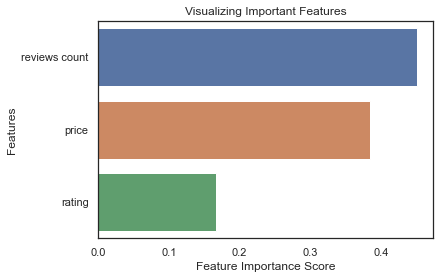

In [105]:
# Feature Ranking reporting, and visualization
feature_imp = pd.Series(clf.feature_importances_,index=features).sort_values(ascending=False)
print(feature_imp)

# Creating a bar plot 
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

**Final Conclusions**

The Random Forest obtained a much better F1-score than one decision tree on its own. Interestingly, one difference between the single decision tree and the Random Forest was the ranking of features: while both ranked the number of reviews the highest, the second highest feature for the single tree was the rating; but on the Random Forest, it was the price. No binarization was applied to the Random Forest, as it was not that helpful on the Decision Tree to begin with.

## Which Model is the Best? (5-Fold Cross Validation)
We saw the confusion matrices for each of the models above, but how do we know that how the data was split into (training and testing sets) may have been affecting our results?

To find out, we will recreate the best version of each model we created, for each model type. We will run 5-fold cross validation, and score based on the f1-score, since that is the best metric to measure the model's prowess.

At the end, the model with the highest mean F1-score, with the lowest variance (as measured with standard deviation) across all its 5 folds, will earn the title of *the best ML algorithm* in this exploration!

### Cross Validation for Support Vector Machine

In [90]:
# use the linear kernel, trained on principal components of standard scaled data
svm = pca_s_svms[0]
X_reduced = pca.transform(X)
all_f1 = cross_val_score(estimator=svm, X=X_reduced, y=y, cv=5, scoring='f1')
svm_scores = [all_f1.mean(), all_f1.std()]
print(svm_scores)

[0.677817034526426, 0.01633436330726263]


### Cross Validation for Logistic Regression

In [84]:
# using the logistic regression model trained on standard scaled data
all_f1 = cross_val_score(estimator=logreg3, X=X_reduced, y=y, cv=5, scoring='f1')
logreg_scores = [all_f1.mean(), all_f1.std()]
print(logreg_scores)

[0.6654975376426127, 0.007949180608974909]


### Cross Validation for K-Nearest Neighbors

In [85]:
# using the knn trained on mixed, standard scaled data
all_f1 = cross_val_score(estimator=knn2, X=X, y=y, cv=5, scoring='f1')
knn_scores = [all_f1.mean(), all_f1.std()]
print(knn_scores)

[0.8602334007797984, 0.02810402287906277]


### Cross Validation for Decision Tree

In [86]:
# using the only decision tree made
all_f1 = cross_val_score(estimator=dt, X=X, y=y, cv=5, scoring='f1')
dt_scores = [all_f1.mean(), all_f1.std()]
print(dt_scores)

[0.7063686638010032, 0.022781727761547802]


### Cross Validation for Random Forest

In [107]:
# using the random forest classifier
all_f1 = cross_val_score(estimator=clf, X=X, y=y, cv=5, scoring='f1')
rand_forest_scores = [all_f1.mean(), all_f1.std()]
print(rand_forest_scores)

[0.8799647727113843, 0.014988566847155828]


### Variance and Mean Compared
The model with lower variance in its F1-Score will take precedence over a model with a higher mean F1-score, as obtained by cross validation. However, mean will be accounted for if two models have an equally low standard deviation in their F1-score.

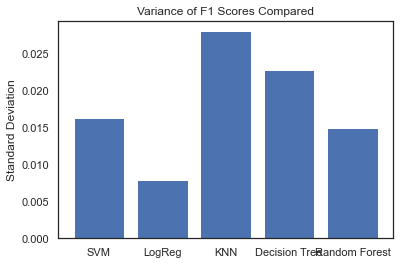

In [108]:
labels = ['SVM', 'LogReg', 'KNN', 'Decision Tree', 'Random Forest']
# bar plot to compare standard deviances
stds = [
    svm_scores[1],
    logreg_scores[1],
    knn_scores[1],
    dt_scores[1],
    rand_forest_scores[1]
]

fig, ax = plt.subplots()
ax.set_ylabel('Standard Deviation')
plt.title('Variance of F1 Scores Compared')
plt.bar(labels, stds)
plt.show()

Okay, so SVM definitely wins!
Just for fun, let's also see how the three models compare on their mean F1-score:

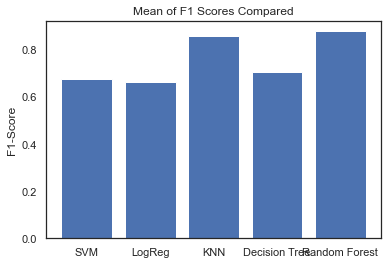

In [109]:
# bar plot to compare means
means = [
    svm_scores[0],
    logreg_scores[0],
    knn_scores[0],
    dt_scores[0],
    rand_forest_scores[0]
]

fig, ax = plt.subplots()
ax.set_ylabel('F1-Score')
plt.title('Mean of F1 Scores Compared')
plt.bar(labels, means)
plt.show()

# Final Conclusions

**Which model performed the best?**

Based upon the different classifiers used in this notebook, the best results have so far been obtained by the Logistic Regression classifer. This model was trained using principal components of the dataset, which was then scaled to a normal distribution. It was able to obtain an F1-Score of 0.7034 at best. This means that for a given book listed on either Amazon or Flipkart, the model would have about 70% probability of correctly classifying where to go to buy that book online.

**Why did the Logistic Regression perform the best?**

While not having the best F1-score overall from amongst all the types of models used, the Logistic Regression wins on having the lowest variance in its F1-score, as shown above. This means the results are the most reliable, and can scale the most effectively, hypothetically as the dataset grows. Also it is important to note that while some models such as the K-Nearest Neighbors had a greater mean F1-score than the Logistic Regression model, but upon further inspection we can see they were overfitting. Therefore, this suggests the Logsistic Regression model would work the best as the dataset grows, because it is not overly specialized to our dataset as it is now.

**Future Improvements**

To improve this study, more work could be done to optimize the hyperparameters in the models used so far. For example, using grid search to figure out the optimal number of estimators to use in Random Forest. Other factors could be further experimented with as well, such as the ordering of books in the DataFrame. This could potentially enlighten the way to increasing F1-scores.